### Experimental GRU Model 

#### Ref: https://www.kaggle.com/jsvishnuj/fakenews-detection-using-lstm-neural-network

In [1]:
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random as rn
import numpy as np
import pandas as pd


In [2]:
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
combined_df = pd.read_csv('processed_ds.csv')
combined_df.head(15)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",1


In [4]:
feature_df = pd.read_csv('feature_df.csv') 
feature_df.head(5)

,id,ambg,lex_div,neg,neu,pos,compound,tfid,label
0,411,129.500000,0.958333,0.0000,0.942500,0.057500,0.25530,0.025000,1
1,502,196.000000,0.814815,0.0000,1.000000,0.000000,0.00000,0.040909,1
2,506,281.500000,0.821870,0.0000,0.922500,0.077500,0.43160,0.011544,1
3,530,88.166667,0.953922,0.0000,0.946667,0.053333,0.10195,0.012000,1
4,541,169.500000,0.910401,0.0795,0.876500,0.044000,-0.08895,0.015957,1


In [ ]:
'''
Multidimension
Title: 20 word vector
Text: 100 word 
Subject: 5
Truncate rest
Date: long form int (size 1)
'''

In [5]:
data_y = combined_df['label'].values
data_x = combined_df.drop('label', 1)

data_x.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

max_features = 4500

# Tokenizing the text - converting the words, letters into counts or numbers. 
# Remove the punctuations
tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = data_x['text'])

Using TensorFlow backend.


In [7]:
tokenized_x = np.squeeze(tokenizer.texts_to_sequences(texts = data_x['text']))

In [ ]:
'''
token_list = [len(x) for x in tokenized_x]
pd.DataFrame(token_list).describe()
'''

In [12]:
X = tokenizer.texts_to_sequences(texts = data_x['text'])
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, data_y, test_size = 0.2, random_state = 44)

In [10]:
from tensorflow import keras 
from tensorflow.keras import layers

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

# GRU neural Network
gru_model = Sequential(name = 'gru_nn_model')
gru_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = '1st_layer'))

gru_model.add(layer = GRU(units = 120, dropout = 0.2, recurrent_dropout = 0.2, recurrent_activation = 'relu', activation = 'relu', name = '2nd_layer'))

gru_model.add(layer = Dropout(rate = 0.4, name = '3rd_layer'))
gru_model.add(layer = Dense(units = 120, activation = 'relu', name = '4th_layer'))

gru_model.add(layer = Dropout(rate = 0.2, name = '5th_layer'))
#gru_model.add(layer = Dense(units = 1, activation = 'sigmoid', name = 'output_layer'))
gru_model.add(layer = Dense(units = len(set(y_test)), activation = 'softmax', name = 'output_layer'))


In [13]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
# compiling the model
gru_model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

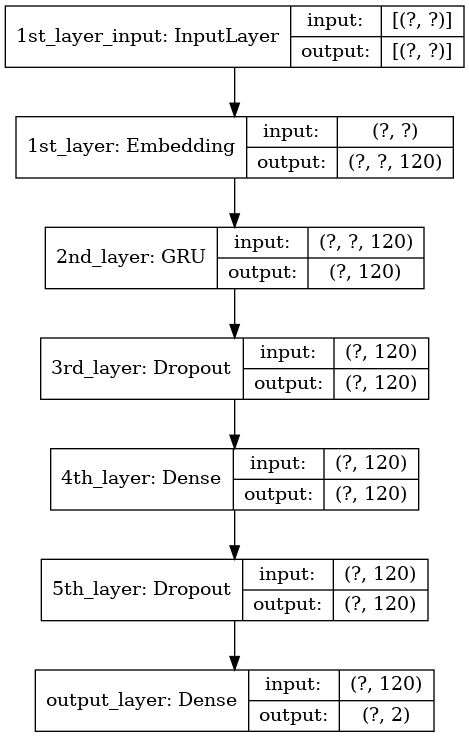

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(gru_model, to_file='gru_nn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
gru_model_fit = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 1)

In [17]:
import pickle

with open('tokenizer', 'wb') as f:
    pickle.dump(tokenizer, f)

In [18]:
def convertText(text_body):
    tokenized_text = tokenizer.texts_to_sequences([sample_text])
    # now applying padding to make them even shaped.
    padded_text = pad_sequences(sequences = tokenized_text, maxlen = max_features, padding = 'pre')
    
    return padded_text[0].reshape(1,-1)

In [ ]:
gru_model.predict(convertText(sample_text))

In [ ]:
gru_model.save('test_gru')

In [ ]:
'''
# Prepare the training dataset.
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
'''